<a href="https://colab.research.google.com/github/manthangadhia/RNN-Stock-Price-Prediction/blob/main/JUBLFOOD_Closing_Prediction_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports
#### All relevant packages and modules (including tf)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as skl

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

---
### Load GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Load, Inspect, and Label Datasets

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving JUBLFOOD_test.csv to JUBLFOOD_test.csv
Saving JUBLFOOD_train.csv to JUBLFOOD_train.csv


In [ ]:
test_df = pd.read_csv('JUBLFOOD_test.csv')
train_df = pd.read_csv('JUBLFOOD_train.csv')

attributes =['Open', 'Close', 'Volume']

---
### Preprocess and scale

For the first try, we will look at only the closing prices. The filtered datasets will then have to be scaled (I will *normalise* using `sklearn`'s `MinMaxScaler`). 

Procedure will be applied to training **and** testing sets, and original copies will be maintained for later access.

In [ ]:
train_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2.713000e+03
mean,839.292747,855.152230,824.446591,839.495522,832.352269,1.419938e+06
std,555.563775,565.405488,546.191164,555.635798,556.342411,1.894752e+06
min,115.474998,117.199997,114.525002,115.199997,113.510651,0.000000e+00
25%,509.000000,517.950012,498.575012,506.524994,499.872772,5.343140e+05
50%,631.500000,642.424988,620.099976,629.825012,620.638245,9.244020e+05
75%,1175.000000,1198.000000,1155.375000,1179.650024,1170.769531,1.620576e+06
max,3190.000000,3215.500000,3050.100098,3203.750000,3203.750000,3.230781e+07


In [ ]:
unscaled_train = train_df.loc[:, attributes]
unscaled_train.head()

,Open,Close,Volume
0,115.474998,116.699997,526144.0
1,116.699997,115.199997,687752.0
2,115.500000,118.275002,1013236.0
3,118.949997,129.125000,11956554.0
4,130.000000,138.274994,7205020.0


In [ ]:
unscaled_train = unscaled_train.values
type(unscaled_train), unscaled_train.shape

(numpy.ndarray, (2721, 3))

---
### Delete NaNs

In [ ]:
# If NaNs present, delete entries.
if np.isnan(unscaled_train).any():

  # Get indices based on only first column of unscaled_train 
  # to make np.argwhere work better
  col = unscaled_train[:, 0]
  
  # Acquire list (of list) of positions with NaNs
  nan_pos = np.argwhere(np.isnan(col))

  unscaled_train = np.delete(unscaled_train, nan_pos.flatten(), axis=0)

print('NaN in train: {}'.format(np.isnan(unscaled_train).any()))

NaN in train: False


---
Normalise training data.

`MinMaxScaler` scales the data to be between $0$ and $1$ by default.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(unscaled_train.reshape(-1, len(attributes)))

---
### Define Timesteps and Label training data

In [ ]:
# The number of timesteps is the number of previous days taken into account to 
# make a prediction for the next day
TIMESTEP = 60

# x_train is a 2D array with len(data)-60 rows and 60 columns
x_train = np.zeros(shape=(len(scaled_train) - TIMESTEP, 
                          len(attributes), 
                          TIMESTEP))

# y_train is a 1D array with len(data)-60 rows
y_train = np.zeros(shape=(len(scaled_train) - TIMESTEP,
                          len(attributes)))

for i, prev_stock in enumerate(range(TIMESTEP, len(scaled_train))):
  x_train[i] = scaled_train[prev_stock-TIMESTEP:prev_stock, 0]
  y_train[i] = scaled_train[prev_stock]

# Attributes are stored as 'Open', 'Close', 'Volume'. We need second attr.
y_train = y_train[:, 1]

x_train.shape, y_train.shape

((2653, 3, 60), (2653,))

`x_train` contains 2661 rows (predictions to be made), each containing the 60 preceeding closing stock prices.

`y_train`  contains 2661 rows of the day's corresponding stock price (label).


Both of these are of type `numpy.ndarray`.

In [ ]:
# Finally reshape to shape=(#samples, #timesteps, #features) due to tf rnn constraints

# x_train = np.reshape(x_train, (x_train.shape[0], 
#                                x_train.shape[1],
#                                x_train.shape[2], 1))
x_train.shape

(2653, 3, 60)

In [ ]:
'''
Trying to rotate x_train such that it has the shape:
  - 2653 rows
  - 60 cols (timesteps)
  - 3 layers (open, close, volume)

i.e. rotate along vertical axis (from axis 1 to axis 2)
'''
x_train = np.rot90(x_train, axes=(1, 2))
x_train.shape

(2653, 60, 3)

---
## Constructing basic RNN
*All relevant libraries have been imported at the top of the notebook.*

The network will be of type `Sequential`, containing `LSTM` layers and `Dense` layers which will be added sequentially.

In [ ]:
with tf.device(device_name):
  # Define and "initialise" network
  rnn = Sequential()

  # Define relevant parameters and add LSTM layers
  units = 60
  drop = 0.15
  # units_last = 30
  ret_seq = [True, True, True, True, True, False]
  ret_seq2 = [True, True, False]
  
  # input_shape takes (Samples= >=1, TIMESTEPS, Features)
  input_shape = (x_train.shape[1], x_train.shape[2]) # Num samples is assumed to be at least 1

  rnn.add(LSTM(units=units, return_sequences=True,
               dropout=drop, 
               input_shape=input_shape))
  for ret in ret_seq:
    rnn.add(LSTM(units=units, return_sequences=ret, 
                 dropout=drop))
  rnn.add(Dense(units=265, activation='sigmoid'))
  rnn.add(Dense(units=10, activation='sigmoid'))
  rnn.add(Dense(units=3))

### RNN Structure
The RNN being used has the following structure:
*  LSTM ($60n$) 
*  LSTM ($60n$, `dropout`=$0.25$) $\times 3$
*  Dense ($10n$)
*  Dense ($1n$)

*All initial LSTM layers have `return_sequences=True`.*

### Compile and Fit NN
Optimiser being used will be `adam`, and loss function used will be means squared loss since we are dealing with continuous data.

In [ ]:
optim  = tf.keras.optimizers.Adam(clipvalue=1.0)

# Compile network (and allow for concrete initialisation of layers)
rnn.compile(optimizer = optim, loss = 'mean_absolute_percentage_error')

In [ ]:
rnn.fit(x_train, y_train, epochs=300, batch_size=48)

Epoch 1/300
56/56 [==============================] - 12s 22ms/step - loss: 19.6353
Epoch 2/300
56/56 [==============================] - 1s 22ms/step - loss: 14.2539
Epoch 3/300
56/56 [==============================] - 1s 23ms/step - loss: 14.2114
Epoch 4/300
56/56 [==============================] - 1s 22ms/step - loss: 13.9384
Epoch 5/300
56/56 [==============================] - 1s 22ms/step - loss: 14.0269
Epoch 6/300
56/56 [==============================] - 1s 23ms/step - loss: 12.9484
Epoch 7/300
56/56 [==============================] - 1s 22ms/step - loss: 11.8137
Epoch 8/300
56/56 [==============================] - 1s 23ms/step - loss: 11.5764
Epoch 9/300
56/56 [==============================] - 1s 22ms/step - loss: 11.6685
Epoch 10/300
56/56 [==============================] - 1s 22ms/step - loss: 11.2200
Epoch 11/300
56/56 [==============================] - 1s 22ms/step - loss: 12.2144
Epoch 12/300
56/56 [==============================] - 1s 23ms/step - loss: 11.4080
Epoch 13/300

---
## Process and Inspect Test Data

Filter to remain with only closing prices.

In [ ]:
unscaled_test = test_df.loc[:, attributes].values
type(unscaled_test), unscaled_test.shape

(numpy.ndarray, (82, 3))

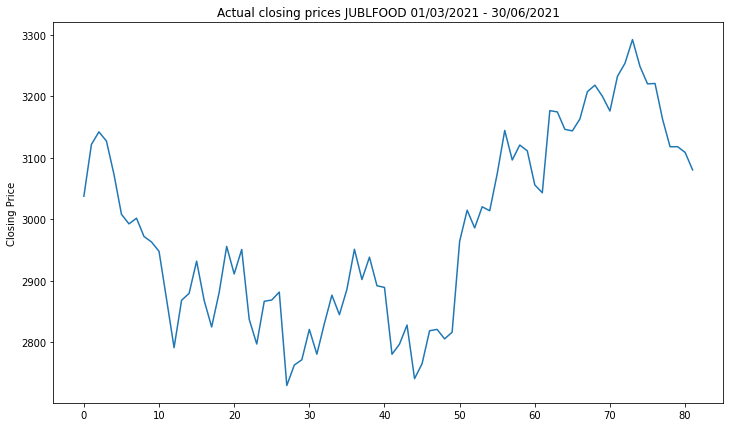

In [ ]:
test_opening, test_closing, test_volume = unscaled_test[:, 0], unscaled_test[:, 1], unscaled_test[:, 2]
plt.figure(figsize=(12,7))
plt.plot(test_closing)
plt.title('Actual closing prices JUBLFOOD 01/03/2021 - 30/06/2021')
plt.ylabel('Closing Price')
plt.show()

## Predictions


---
### Collect all required datapoints
In order to make predictions for the test set, we need to have the previous `TIMESTEP` datapoints from the training set. For this, I will take the last `TIMESTEP` entries from the unscaled training data and append them to the front of all the unscaled testing data.

In [ ]:
# Copy the last 60 elements of unscaled_train to a new array
train_timesteps = unscaled_train[-TIMESTEP:]
train_timesteps.shape

(60, 3)

In [ ]:
#  Concatenate the training timesteps and check that the numbers match up
concat_test = np.concatenate((train_timesteps, unscaled_test))
concat_test.shape, unscaled_test.shape

((142, 3), (82, 3))

---
### Formatting
Concatenated data array must be reshaped to be usable with `rnn.predict`. Then this data must be scaled similar to the training data, and grouped by each day.

In [ ]:
# Reshape
concat_test = np.reshape(concat_test, (-1, len(attributes)))

In [ ]:
# Scale
unscaled_close = concat_test[:, 1]
test_sc = MinMaxScaler()
scaled_test = test_sc.fit_transform(unscaled_close.reshape(-1, 1))

In [ ]:
# Group into rows of 60 columns
days_pred = unscaled_test.shape[0]  # Should equate to 82 for current JUBLFOODS test
x_test = np.zeros(shape=(days_pred, TIMESTEP, len(attributes)))

for i, prev_stock in enumerate(range(TIMESTEP, len(scaled_test))):
  x_test[i] = scaled_test[prev_stock-TIMESTEP:prev_stock]


# Reshape one more time to meet tf predict requirements
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(attributes)))
x_test.shape

(82, 60, 3)

---
### Finally make predictions

In [ ]:
predictions = rnn.predict(x_test)

ValueError: ignored

In [ ]:
predictions.shape

(82, 1)

This array of predictions is scaled, and therefore does not clearly represent real-world pricing information in a way that is understandeable. We first need to "un-scale" the predictions.

In [ ]:
unscaled_predictions = scaler.inverse_transform(predictions)

ValueError: ignored

---
### Evaluate predictive performance

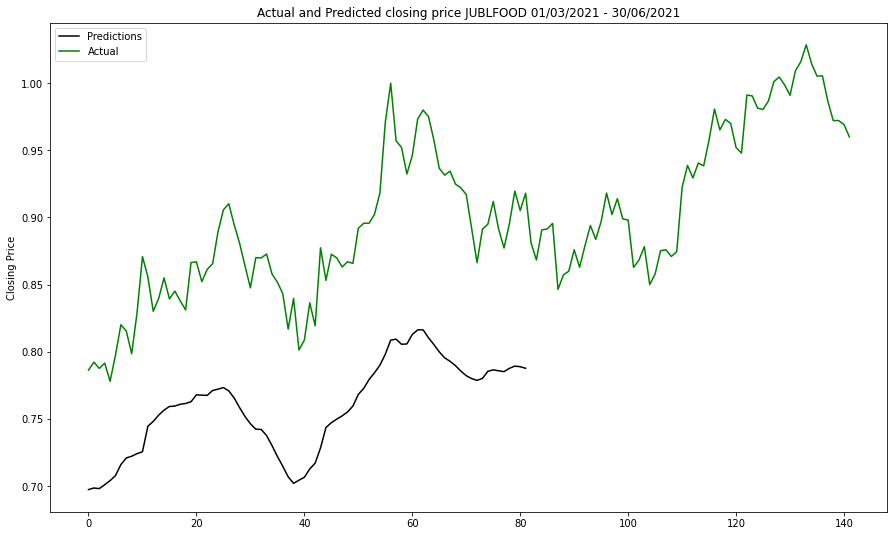

In [ ]:
close = scaled_test[:, 1]
plt.figure(figsize=(15,9))
plt.plot(predictions, color='black', label='Predictions')
plt.plot(close, color='green', label='Actual')
plt.legend()
plt.title('Actual and Predicted closing price JUBLFOOD 01/03/2021 - 30/06/2021')
plt.ylabel('Closing Price')
plt.show()